In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder

In [ ]:
data_df = pd.read_csv("./Resources/cleaned_bids.csv")
# data_df = pd.read_csv("cleaned_bids.csv")
print(data_df.shape)
data_df.head()

(7656334, 9)


,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url
0,0.0,8dac2b259fd1c6d1120e519fb1ac14fbqvax8,ewmzr,jewelry,phone0,9759243157894736,us,69.166.231.58,vasstdc27m7nks3
1,1.0,668d393e858e8126275433046bbd35c6tywop,aeqok,furniture,phone1,9759243157894736,in,50.201.125.84,jmqlhflrzwuay9c
2,2.0,aa5f360084278b35d746fa6af3a7a1a5ra3xe,wa00e,homegoods,phone2,9759243157894736,py,112.54.208.157,vasstdc27m7nks3
3,3.0,3939ac3ef7d472a59a9c5f893dd3e39fh9ofi,jefix,jewelry,phone4,9759243157894736,in,18.99.175.133,vasstdc27m7nks3
4,4.0,8393c48eaf4b8fa96886edc7cf27b372dsibi,jefix,jewelry,phone5,9759243157894736,in,145.138.5.37,vasstdc27m7nks3


#### Calculate time interval<br>
First sort the bidder_id and time, so we can calculate the bidder's bidding time interval later.<br>
Second get time difference between two bids of one bidder. 

In [ ]:
# Step 1: Sort the bidder_id and time
bids_df = data_df.sort_values(["bidder_id", "time"], ascending= True)
print(bids_df.shape)

(7656334, 9)


In [ ]:
# Step 2: Get the time interval of each bidder between each bid
timediff = bids_df.groupby("bidder_id")["time"].diff()
bids_df["timediff"] = timediff
print(bids_df.shape)
bids_df.head()

(7656334, 10)


,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,timediff
7179832,7179832.0,001068c415025a009fee375a12cff4fcnht8y,4ifac,jewelry,phone561,9706345052631578,bn,139.226.147.115,vasstdc27m7nks3,NaN
1281292,1281292.0,002d229ffb247009810828f648afc2ef593rb,2tdw2,mobile,phone640,9766744105263157,sg,37.40.254.131,vasstdc27m7nks3,NaN
1281311,1281311.0,002d229ffb247009810828f648afc2ef593rb,2tdw2,mobile,phone219,9766744210526315,sg,37.40.254.131,vasstdc27m7nks3,105263158.0
6805028,6805028.0,0030a2dd87ad2733e0873062e4f83954mkj86,obbny,mobile,phone313,9704553947368421,ir,21.67.17.162,vnw40k8zzokijsv,NaN
3967330,3967330.0,003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,obbny,mobile,phone420,9640018631578947,id,44.241.8.179,sj4jidex850loas,NaN


Question:
However, if the time interval is over the auction duration, the time_diff may not useful.<br>
1. Replace the time_diff if the interval is over the max of auction duration
2. Replace the time_diff if the interval is over the mean of auction duration
3. Ignore this??

In [ ]:
# pd.set_option('display.max_rows', 500) # Display all the country
# countries

In [ ]:
# Rank the bidding order
bids_df["bidding_order"] = bids_df.groupby("auction")["time"].rank(method="min")
bids_df.sort_values(by=["auction", "time"], inplace=True)
bids_df = bids_df.reset_index(drop=True)
print(bids_df.shape)
bids_df.head()

(7656334, 11)


,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,timediff,bidding_order
0,5826422.0,92af1e40713e077ef87f5352fb56772fjnzm7,00270,mobile,phone563,9699049894736842,us,78.188.245.105,vuaaeraf3dqz299,7.368421e+09,1.0
1,5834284.0,a939f51234ad2c44eb9ccc84e754f41foiv7g,00270,mobile,phone63,9699098210526315,us,12.142.135.122,fbpq1mgtpgnkqnk,2.852632e+10,2.0
2,5850448.0,92af1e40713e077ef87f5352fb56772fjnzm7,00270,mobile,phone735,9699195789473684,us,2.86.254.154,nn2g552xadgkfch,1.068421e+10,3.0
3,5884054.0,9655ccc7c0c193f1549475f02c54dce45kjw7,00270,sportinggoods,phone573,9699392473684210,us,149.152.163.145,vasstdc27m7nks3,1.578947e+08,4.0
4,5898318.0,9655ccc7c0c193f1549475f02c54dce45kjw7,00270,sportinggoods,phone2294,9699474473684210,us,219.254.45.139,vasstdc27m7nks3,5.263158e+07,5.0


### Group by bidders

If only used bidders.csv to train the model and got the importances, merchandise_count has 0 important score. Therefore, it should be drop for further analysis.
<br>
<br>Importance results got from BalancedRandomForestClassifier: <br>

	Features	Feature Score
0.	time_median	   0.241426 <br>
1.	time_mean	   0.221284<br>
2.	auction_count	0.130564<br>
3.	ip_count	    0.114091<br>
4.	time_std	    0.106800<br>
5.	device_count	0.066883<br>
6.	url_count	0.064681<br>
7.	country_count	0.054271<br>
8.	merchandise_count	0.000000<br>

In [ ]:
# Create a founction to count unique values
def count_items(data):
    counts = {}
    for var in object_cols:
        count_str = var + "_count"
        counts[count_str]  = data[var].nunique()

    counts["bidder_rank_min"] = data["bidding_order"].min() # The fastest bidding rank the bider has
    counts["bid_count"] = data["bid_id"].count()
    counts = pd.Series(counts)
    return counts

In [ ]:
# Count number of auctions, merchandise, devices, countries, ips, urls per bidder has
# object_cols = ["auction", "merchandise", "device", "country", "ip", "url"]
object_cols = ["auction", "device", "country", "ip", "url"]
bidders = bids_df.groupby("bidder_id").apply(count_items)
print(bidders.shape)
bidders.head()

(6614, 7)


,auction_count,device_count,country_count,ip_count,url_count,bidder_rank_min,bid_count
bidder_id,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1.0,1.0,1.0,1.0,1.0,1899.0,1.0
002d229ffb247009810828f648afc2ef593rb,1.0,2.0,1.0,1.0,1.0,51.0,2.0
0030a2dd87ad2733e0873062e4f83954mkj86,1.0,1.0,1.0,1.0,1.0,23448.0,1.0
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3.0,3.0,1.0,3.0,2.0,121.0,3.0
00486a11dff552c4bd7696265724ff81yeo9v,13.0,8.0,1.0,10.0,7.0,62.0,20.0


In [ ]:
mean_diff = bids_df.groupby(["bidder_id"])["timediff"].mean()
mean_diff = mean_diff.fillna(mean_diff.mean()) 
bidders["time_mean"] = mean_diff

median_diff = bids_df.groupby(["bidder_id"])["timediff"].median()
median_diff = median_diff.fillna(median_diff.mean()) 
bidders["time_median"] = median_diff

std_diff = bids_df.groupby(["bidder_id"])["timediff"].std()
std_diff = std_diff.fillna(std_diff.mean()) 
bidders["time_std"] = std_diff

print(bidders.shape)
bidders.head()

(6614, 10)


,auction_count,device_count,country_count,ip_count,url_count,bidder_rank_min,bid_count,time_mean,time_median,time_std
bidder_id,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1.0,1.0,1.0,1.0,1.0,1899.0,1.0,3.488293e+12,2.212457e+12,5.027686e+12
002d229ffb247009810828f648afc2ef593rb,1.0,2.0,1.0,1.0,1.0,51.0,2.0,1.052632e+08,1.052632e+08,5.027686e+12
0030a2dd87ad2733e0873062e4f83954mkj86,1.0,1.0,1.0,1.0,1.0,23448.0,1.0,3.488293e+12,2.212457e+12,5.027686e+12
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,3.0,3.0,1.0,3.0,2.0,121.0,3.0,3.297784e+13,3.297784e+13,3.904443e+13
00486a11dff552c4bd7696265724ff81yeo9v,13.0,8.0,1.0,10.0,7.0,62.0,20.0,4.018413e+12,9.177368e+11,1.153730e+13


In [ ]:
# Save bidders
bidders.to_csv("./Resources/bidders.csv")
# bidders.to_csv("bidders.csv")

In [ ]:
# # Encode merchandise and country
# country = (bids_df["country"].unique()).tolist()
# merchandise = (bids_df["merchandise"].unique()).tolist()

# def dummy_country_merch(data):
#     count_merch = dict.fromkeys(merchandise, 0)
#     count_merch.update(dict.fromkeys(country, 0))
        
#     for merch, value in data["merchandise"].value_counts().iteritems():
#         count_merch[merch] = value
        
#     for count in data["country"].unique():
#         count_merch[count] = 1
        
#     count_merch = pd.Series(count_merch)
#     return count_merch

In [ ]:
# bidders_count_merch = bids_df.groupby("bidder_id").apply(dummy_country_merch)
# print(bidders_count_merch.shape)
# bidders_count_merch.head()

(6609, 209)


,jewelry,mobile,homegoods,booksandmusic,sportinggoods,officeequipment,furniture,clothing,computers,autoparts,...,vc,je,zz,an,gi,nc,aw,vi,tc,gp
bidder_id,,,,,,,,,,,,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
002d229ffb247009810828f648afc2ef593rb,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0030a2dd87ad2733e0873062e4f83954mkj86,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
00486a11dff552c4bd7696265724ff81yeo9v,0,0,20,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# # Save bidders_count_merch
# bidders_count_merch.to_csv("./Resources/bidders_count_merch.csv", index=False)

## Group by auctions and bidders

In [ ]:
# Count number of devices, countries, ips, urls per bidder has within one auction
# object_cols = ["merchandise", "device", "country", "ip", "url"]
object_cols = ["device", "country", "ip", "url"]
bidder_auc = bids_df.groupby(["bidder_id", "auction"]).apply(count_items)
print(bidder_auc.shape)
bidder_auc.head()

(382341, 6)


device_count  country_count  \
bidder_id                             auction                                
001068c415025a009fee375a12cff4fcnht8y 4ifac             1.0            1.0   
002d229ffb247009810828f648afc2ef593rb 2tdw2             2.0            1.0   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny             1.0            1.0   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6             1.0            1.0   
                                      efh5o             1.0            1.0   

                                               ip_count  url_count  \
bidder_id                             auction                        
001068c415025a009fee375a12cff4fcnht8y 4ifac         1.0        1.0   
002d229ffb247009810828f648afc2ef593rb 2tdw2         1.0        1.0   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny         1.0        1.0   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6         1.0        1.0   
                                      efh5o         1.0        1.0   

                                               bidder_rank_min  bid_count  
bidder_id                             auction                              
001068c415025a009fee375a12cff4fcnht8y 4ifac             1899.0        1.0  
002d229ffb247009810828f648afc2ef593rb 2tdw2               51.0        2.0  
0030a2dd87ad2733e0873062e4f83954mkj86 obbny            23448.0        1.0  
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6              121.0        1.0  
                                      efh5o             2029.0        1.0

In [ ]:
mean_diff = bids_df.groupby(["bidder_id", "auction"])["timediff"].mean()
mean_diff = mean_diff.fillna(mean_diff.mean()) # mean_diff.mean()
bidder_auc["time_mean"] = mean_diff

median_diff = bids_df.groupby(["bidder_id", "auction"])["timediff"].median()
median_diff = median_diff.fillna(median_diff.mean()) # median_diff.mean()
bidder_auc["time_median"] = median_diff

std_diff = bids_df.groupby(["bidder_id", "auction"])["timediff"].std()
std_diff = std_diff.fillna(std_diff.mean()) # std_diff.mean()
bidder_auc["time_std"] = std_diff

print(bidder_auc.shape)
bidder_auc.head()

(382341, 9)


device_count  country_count  \
bidder_id                             auction                                
001068c415025a009fee375a12cff4fcnht8y 4ifac             1.0            1.0   
002d229ffb247009810828f648afc2ef593rb 2tdw2             2.0            1.0   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny             1.0            1.0   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6             1.0            1.0   
                                      efh5o             1.0            1.0   

                                               ip_count  url_count  \
bidder_id                             auction                        
001068c415025a009fee375a12cff4fcnht8y 4ifac         1.0        1.0   
002d229ffb247009810828f648afc2ef593rb 2tdw2         1.0        1.0   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny         1.0        1.0   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6         1.0        1.0   
                                      efh5o         1.0        1.0   

                                               bidder_rank_min  bid_count  \
bidder_id                             auction                               
001068c415025a009fee375a12cff4fcnht8y 4ifac             1899.0        1.0   
002d229ffb247009810828f648afc2ef593rb 2tdw2               51.0        2.0   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny            23448.0        1.0   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6              121.0        1.0   
                                      efh5o             2029.0        1.0   

                                                  time_mean   time_median  \
bidder_id                             auction                               
001068c415025a009fee375a12cff4fcnht8y 4ifac    2.783434e+11  2.580032e+11   
002d229ffb247009810828f648afc2ef593rb 2tdw2    1.052632e+08  1.052632e+08   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny    2.783434e+11  2.580032e+11   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6    6.058642e+13  6.058642e+13   
                                      efh5o    5.369263e+12  5.369263e+12   

                                                   time_std  
bidder_id                             auction                
001068c415025a009fee375a12cff4fcnht8y 4ifac    1.609943e+11  
002d229ffb247009810828f648afc2ef593rb 2tdw2    1.609943e+11  
0030a2dd87ad2733e0873062e4f83954mkj86 obbny    1.609943e+11  
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6    1.609943e+11  
                                      efh5o    1.609943e+11

In [ ]:
# Save bidder_auc to csv
bidder_auc.to_csv("./Resources/bidder_auc.csv", index=False)
# bidder_auc.to_csv("bidder_auc.csv", index=False)

In [ ]:
# bidder_auc_cm = bids_df.groupby(["bidder_id", "auction"]).apply(dummy_country_merch)
# print(bidder_auc_cm.shape)
# bidder_auc_cm.head()

(382324, 209)


jewelry  mobile  homegoods  \
bidder_id                             auction                               
001068c415025a009fee375a12cff4fcnht8y 4ifac          1       0          0   
002d229ffb247009810828f648afc2ef593rb 2tdw2          0       2          0   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny          0       1          0   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6          0       1          0   
                                      efh5o          0       1          0   

                                               booksandmusic  sportinggoods  \
bidder_id                             auction                                 
001068c415025a009fee375a12cff4fcnht8y 4ifac                0              0   
002d229ffb247009810828f648afc2ef593rb 2tdw2                0              0   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny                0              0   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6                0              0   
                                      efh5o                0              0   

                                               officeequipment  furniture  \
bidder_id                             auction                               
001068c415025a009fee375a12cff4fcnht8y 4ifac                  0          0   
002d229ffb247009810828f648afc2ef593rb 2tdw2                  0          0   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny                  0          0   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6                  0          0   
                                      efh5o                  0          0   

                                               clothing  computers  autoparts  \
bidder_id                             auction                                   
001068c415025a009fee375a12cff4fcnht8y 4ifac           0          0          0   
002d229ffb247009810828f648afc2ef593rb 2tdw2           0          0          0   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny           0          0          0   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6           0          0          0   
                                      efh5o           0          0          0   

                                               ...  vc  je  zz  an  gi  nc  \
bidder_id                             auction  ...                           
001068c415025a009fee375a12cff4fcnht8y 4ifac    ...   0   0   0   0   0   0   
002d229ffb247009810828f648afc2ef593rb 2tdw2    ...   0   0   0   0   0   0   
0030a2dd87ad2733e0873062e4f83954mkj86 obbny    ...   0   0   0   0   0   0   
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6    ...   0   0   0   0   0   0   
                                      efh5o    ...   0   0   0   0   0   0   

                                               aw  vi  tc  gp  
bidder_id                             auction                  
001068c415025a009fee375a12cff4fcnht8y 4ifac     0   0   0   0  
002d229ffb247009810828f648afc2ef593rb 2tdw2     0   0   0   0  
0030a2dd87ad2733e0873062e4f83954mkj86 obbny     0   0   0   0  
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o cqsh6     0   0   0   0  
                                      efh5o     0   0   0   0  

[5 rows x 209 columns]

In [ ]:
# # Save bidder_auc_cm to csv
# bidder_auc_cm.to_csv("./Resources/bidder_auc_cm.csv", index=False)

### Binning and Encoding

In [ ]:
bin_encode_df = bids_df.copy()

In [ ]:
# Check the columns with too many categories that need for binning 
bin_encode_df.nunique()

bid_id           7656334
bidder_id           6614
auction            15051
merchandise           10
device              7351
time              776529
country              202
ip               2303991
url              1786351
timediff           37673
bidding_order     384102
dtype: int64

#### Binning the country

(0.0, 100000.0)

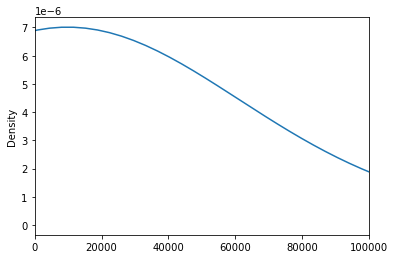

In [ ]:
countries = bin_encode_df["country"].value_counts()
countries.plot.density()
plt.xlim(left=0, right=100000)

In [ ]:
replace_countries = list(countries[countries < 100000].index)
for country in replace_countries:
    bin_encode_df.country = bin_encode_df.country.replace(country, "Others")
    
bin_encode_df.country.value_counts()

Others    2250168
in        1788834
ng         586594
id         453645
us         321265
tr         319619
za         298017
ke         287978
th         238189
my         216809
vn         190362
gh         179223
ru         140387
uk         138692
mx         138653
br         107899
Name: country, dtype: int64

#### Binning for device

(0.0, 100000.0)

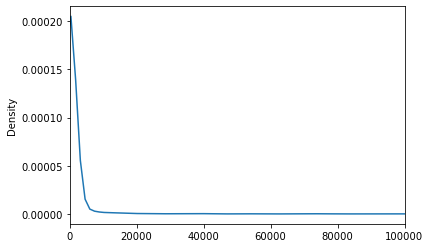

In [ ]:
devices = bin_encode_df["device"].value_counts()
devices.plot.density()
plt.xlim(left=0, right=100000)

In [ ]:
replace_devices = list(devices[devices < 100000].index)
for device in replace_devices:
    bin_encode_df.device = bin_encode_df.device.replace(device, "Others")
    
bin_encode_df.device.value_counts()

Others      5442006
phone4       706573
phone2       171584
phone35      165230
phone65      153855
phone3       153202
phone101     152048
phone45      148388
phone25      126426
phone46      121215
phone17      114389
phone28      100741
phone22      100677
Name: device, dtype: int64

In [ ]:
bin_encode_df.to_csv("./Resources/binned_bids.csv", index=False)

#### Encoding

In [ ]:
columns_to_encode = ["merchandise", "country", "device"]
enc = OneHotEncoder(sparse=False)
encoded_df = pd.DataFrame(enc.fit_transform(bin_encode_df[columns_to_encode]))
encoded_df.columns = enc.get_feature_names_out(columns_to_encode)
print(encoded_df.shape)
encoded_df.head()

(7656334, 39)


C:\Users\Jarvinia\anaconda3\envs\mlenv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,merchandise_autoparts,merchandise_booksandmusic,merchandise_clothing,merchandise_computers,merchandise_furniture,merchandise_homegoods,merchandise_jewelry,merchandise_mobile,merchandise_officeequipment,merchandise_sportinggoods,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
encoded_df.to_csv("./Resources/encoding.csv", index=False)

In [3]:
bin_encode_df = pd.read_csv("/content/drive/Othercomputers/我的笔记本电脑/Bootcamp/Final Project/Human-or-Robot-Facebook-Kaggle/Resources/binned_bids.csv")
encoded_df = pd.read_csv("/content/drive/Othercomputers/我的笔记本电脑/Bootcamp/Final Project/Human-or-Robot-Facebook-Kaggle/Resources/encoding.csv")

In [4]:
bin_encode_df.head()


,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,timediff,bidding_order
0,5826422.0,92af1e40713e077ef87f5352fb56772fjnzm7,00270,mobile,Others,9699049894736842,us,78.188.245.105,vuaaeraf3dqz299,7.368421e+09,1.0
1,5834284.0,a939f51234ad2c44eb9ccc84e754f41foiv7g,00270,mobile,Others,9699098210526315,us,12.142.135.122,fbpq1mgtpgnkqnk,2.852632e+10,2.0
2,5850448.0,92af1e40713e077ef87f5352fb56772fjnzm7,00270,mobile,Others,9699195789473684,us,2.86.254.154,nn2g552xadgkfch,1.068421e+10,3.0
3,5884054.0,9655ccc7c0c193f1549475f02c54dce45kjw7,00270,sportinggoods,Others,9699392473684210,us,149.152.163.145,vasstdc27m7nks3,1.578947e+08,4.0
4,5898318.0,9655ccc7c0c193f1549475f02c54dce45kjw7,00270,sportinggoods,Others,9699474473684210,us,219.254.45.139,vasstdc27m7nks3,5.263158e+07,5.0


In [36]:
encoded_df.head()

,merchandise_autoparts,merchandise_booksandmusic,merchandise_clothing,merchandise_computers,merchandise_furniture,merchandise_homegoods,merchandise_jewelry,merchandise_mobile,merchandise_officeequipment,merchandise_sportinggoods,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
pre_encode = bin_encode_df.copy()
pre_encode.head()

,bid_id,bidder_id,auction,merchandise,device,time,country,ip,url,timediff,bidding_order
0,5826422.0,92af1e40713e077ef87f5352fb56772fjnzm7,00270,mobile,Others,9699049894736842,us,78.188.245.105,vuaaeraf3dqz299,7.368421e+09,1.0
1,5834284.0,a939f51234ad2c44eb9ccc84e754f41foiv7g,00270,mobile,Others,9699098210526315,us,12.142.135.122,fbpq1mgtpgnkqnk,2.852632e+10,2.0
2,5850448.0,92af1e40713e077ef87f5352fb56772fjnzm7,00270,mobile,Others,9699195789473684,us,2.86.254.154,nn2g552xadgkfch,1.068421e+10,3.0
3,5884054.0,9655ccc7c0c193f1549475f02c54dce45kjw7,00270,sportinggoods,Others,9699392473684210,us,149.152.163.145,vasstdc27m7nks3,1.578947e+08,4.0
4,5898318.0,9655ccc7c0c193f1549475f02c54dce45kjw7,00270,sportinggoods,Others,9699474473684210,us,219.254.45.139,vasstdc27m7nks3,5.263158e+07,5.0


In [6]:
bidder_id = pre_encode[["bidder_id"]]
# pre_encode = pre_encode.drop(columns= ["bid_id","merchandise", "country", "device", "time", "url", "ip", "timediff", "bidding_order"] , axis=1)
bidder_id.head()

,bidder_id
0,92af1e40713e077ef87f5352fb56772fjnzm7
1,a939f51234ad2c44eb9ccc84e754f41foiv7g
2,92af1e40713e077ef87f5352fb56772fjnzm7
3,9655ccc7c0c193f1549475f02c54dce45kjw7
4,9655ccc7c0c193f1549475f02c54dce45kjw7


In [7]:
merged_encoded_df = bidder_id.merge(encoded_df, left_index=True, right_index=True)
print(merged_encoded_df.shape)
merged_encoded_df.head()

(7656334, 40)


,bidder_id,merchandise_autoparts,merchandise_booksandmusic,merchandise_clothing,merchandise_computers,merchandise_furniture,merchandise_homegoods,merchandise_jewelry,merchandise_mobile,merchandise_officeequipment,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
0,92af1e40713e077ef87f5352fb56772fjnzm7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,a939f51234ad2c44eb9ccc84e754f41foiv7g,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,92af1e40713e077ef87f5352fb56772fjnzm7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,9655ccc7c0c193f1549475f02c54dce45kjw7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,9655ccc7c0c193f1549475f02c54dce45kjw7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
merged_encoded_df.to_csv("merged_encoded.csv")

In [9]:
bidder_encode = merged_encoded_df.copy()

In [13]:
bidder_encoding = bidder_encode.groupby("bidder_id").sum()
print(bidder_encoding.shape)
bidder_encoding.head()

(6614, 39)


,merchandise_autoparts,merchandise_booksandmusic,merchandise_clothing,merchandise_computers,merchandise_furniture,merchandise_homegoods,merchandise_jewelry,merchandise_mobile,merchandise_officeequipment,merchandise_sportinggoods,...,device_phone2,device_phone22,device_phone25,device_phone28,device_phone3,device_phone35,device_phone4,device_phone45,device_phone46,device_phone65
bidder_id,,,,,,,,,,,,,,,,,,,,,
001068c415025a009fee375a12cff4fcnht8y,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
002d229ffb247009810828f648afc2ef593rb,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0030a2dd87ad2733e0873062e4f83954mkj86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
003180b29c6a5f8f1d84a6b7b6f7be57tjj1o,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00486a11dff552c4bd7696265724ff81yeo9v,0.0,0.0,0.0,0.0,0.0,20.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,7.0,5.0,0.0,2.0


In [14]:
bidder_encoding.to_csv("bidder_encoding.csv", index=False)

In [8]:
bidder_encode.loc[bidder_encode["bidder_id"] == "00486a11dff552c4bd7696265724ff81yeo9v"].sum()["merchandise_homegoods"]

20.0

In [ ]:
merged_encoded.csv is 1.5G and my computer couldn't run the groupby funcion of 